### Compares LGARTO (C) real examples against Hydrus
### Date: 23 October, 2024 (last updated)
### Peter La Follette

In [ ]:
#the prupose of this notebook is to demonstrate how LGARTO compares to a HYDRUS simulation
#in a humid environment. 

#Forcing and soils data for this simulation, for both HYDRUS and LGARTO, are taken from the
#USDA SCAN site near Kukuihaele, HI. 

#This site is probably the most dynamic of the 4 sites, incofporating both extremely wet
#periods where the model reaches complete saturation, as well as a relatively dry period
#for which there is negative recharge.

#This notebook shows that in terms of infiltration, AET, and runoff, LGARTO does pretty well
#in emulating HYDRUS results. LGARTO recharge is decent in that cumulative recharge
#is comprable to HYDRUS, but the simulation does highlight how LGARTO simulates less negative
#recharge compared to HYDRUS (possibly because the diffusion term present in the Rihcards
#equation is neglected in LGAR / LGARTO).

#Still, the results are comprable to HYDRUS, such that using LGARTO in lieu of a Richards 
#equation solver in the context of a hydrolgic model seems promising. 

In [272]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
import importlib as imp
import copy
import pandas as pd
import datetime as dt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

import pickle

import hydroeval

In [273]:
# C version
sim_case = 'outputs/Kukuihaele/data_variables.csv' 
c_path_vars = sim_case

outfile = "c-hydrus-comparison_Kukuihaele.png"
outfile_summpary_plot = "c-hydrus-comparison_Kukuihaele_summary.png"

save_outfile = True

In [274]:
num_steps = 8760
    
start = pd.Timestamp("2018-10-01 00:00:00")
end = pd.Timestamp("2019-10-01 00:00:00")
times = pd.date_range(start=start,end=end, periods=num_steps) #freq='min'
times_bmi = pd.date_range(start=start,end=end, periods=num_steps)

xfmt = mdates.DateFormatter('%Y/%m/%d')

In [275]:
data_c_vars = pd.read_csv(c_path_vars)
data_c_vars = data_c_vars[0:num_steps]
data_c_vars.head()

,Time,precipitation,potential_evapotranspiration,actual_evapotranspiration,surface_runoff,giuh_runoff,soil_storage,total_discharge,infiltration,percolation,groundwater_to_stream_recharge,mass_balance
0,2018-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.404359,0.0,0.0,0.000000e+00,0.0,0.0
1,2018-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.404359,0.0,0.0,-2.995000e-12,0.0,-0.0
2,2018-10-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.404359,0.0,0.0,-1.453000e-12,0.0,0.0
3,2018-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.404359,0.0,0.0,-1.000000e-12,0.0,-0.0
4,2018-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.404359,0.0,0.0,-8.260000e-13,0.0,0.0


In [276]:
m_to_mm = 1000


### Read Hydrus data

In [277]:

hyd_path = 'HYDRUS_outputs/Kukuihaele/T_Level.txt'

HYDRUS_output = pd.read_fwf(hyd_path,widths=[13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13])            
HYDRUS_datetime_vec = []
for i in range(0,len(HYDRUS_output['Time'])):
    current_dt = dt.datetime.strptime(data_c_vars['Time'][0],'%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=HYDRUS_output['Time'][i])
    HYDRUS_datetime_vec.append(current_dt)
HYDRUS_output['HYDRUS_datetime_vec'] = HYDRUS_datetime_vec
HYDRUS_output = HYDRUS_output.set_index('HYDRUS_datetime_vec')

# HYDRUS_output = HYDRUS_output.resample('3600s').pad()

HYDRUS_output = HYDRUS_output[0:num_steps]

HYDRUS_output.head()



,Time,rTop,rRoot,vTop,vRoot,vBot,sum(rTop,) sum(rRoot,) sum(vTop,) sum(vRoot,...,hRoot,hBot,RunOff,sum(RunOff,) Volume,sum(Infil,) sum(Evap,) TLevel Cum(,WTrans) Snow,Layer
HYDRUS_datetime_vec,,,,,,,,,,,,,,,,,,,,,
2018-10-01 01:00:00,1.0,0.0,0.0,-1.627200e-09,0.0,0.000000e+00,0.0,0.0,-1.627200e-09,0.0,...,-82.230,0.0,0.0,0.0,40.451,0.0,0.000000e+00,13 0.00,0.0,0.0
2018-10-01 02:00:00,2.0,0.0,0.0,-4.895100e-08,0.0,-2.717800e-09,0.0,0.0,-2.397100e-11,0.0,...,-82.231,0.0,0.0,0.0,40.451,0.0,9.445200e-09,26 0.00,0.0,0.0
2018-10-01 03:00:00,3.0,0.0,0.0,5.309900e-08,0.0,-2.717800e-09,0.0,0.0,8.607500e-09,0.0,...,-82.231,0.0,0.0,0.0,40.451,0.0,2.640900e-08,39 0.00,0.0,0.0
2018-10-01 04:00:00,4.0,0.0,0.0,1.364300e-08,0.0,-2.717800e-09,0.0,0.0,1.832300e-08,0.0,...,-82.231,0.0,0.0,0.0,40.451,0.0,4.067200e-08,52 0.00,0.0,0.0
2018-10-01 05:00:00,5.0,0.0,0.0,-7.313000e-08,0.0,-2.717800e-09,0.0,0.0,2.000600e-08,0.0,...,-82.231,0.0,0.0,0.0,40.451,0.0,5.961200e-08,65 0.00,0.0,0.0


0       0.000000e+00
1      -2.995000e-10
2      -4.448000e-10
3      -5.448000e-10
4      -6.274000e-10
            ...     
8755    1.800353e+01
8756    1.800344e+01
8757    1.800334e+01
8758    1.800324e+01
8759    1.800314e+01
Name: percolation, Length: 8760, dtype: float64


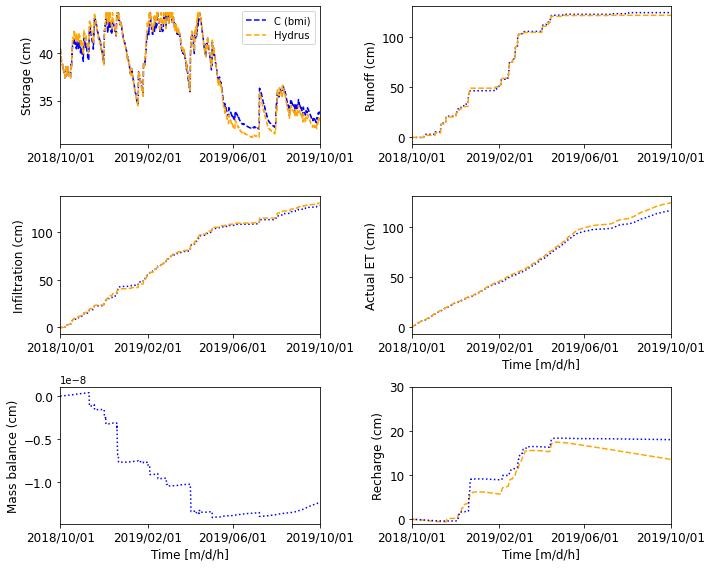

In [278]:

#%matplotlib qt
fig, axs = plt.subplots(3,2, figsize=(10,8), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

vars_bmi = ['soil_storage', 'surface_runoff', 'infiltration', 'actual_evapotranspiration', 'mass_balance', 'percolation']
vars_hydrus = [')     Volume', 'sum(RunOff', 'sum(Infil', ')   sum(vRoot', ')    sum(vBot']
m_to_mm = 1000
m_to_cm = 100
timestep = 300/3600
y_labels = ['Storage (cm)', 'Runoff (cm)', 'Infiltration (cm)', 'Actual ET (cm)', 'Mass balance (cm)', 'Recharge (cm)']

for i in range(len(y_labels)):
    if i == 0:
        if i == 0:
            axs[i].plot(times_bmi, data_c_vars[vars_bmi[i]]*m_to_cm,'b',linestyle='dashed',label='C (bmi)')
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        else:
            hyd = []
            for t,v1 in zip(HYDRUS_output['Time'], HYDRUS_output[vars_hydrus[0]]):
                if t % 5.0 == 0:
                    hyd.append(v1)
            hyd_c_diff = []

            #hydrus output data does not include t=0 data
            for v2, v3 in zip(np.array(hyd),np.array(data_c_vars[vars_bmi[0]]*m_to_cm)[1:]):
                hyd_c_diff.append(abs(v2-v3))

            axs[i].legend()
        
    elif (i < len(vars_hydrus)-1):
        if i == 1 or i == 2 or i ==3 : 
            
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')  
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        if i==4:
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
            axs[4].axis(ymin=-1,ymax=1)
    elif (i==4):
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
        axs[5].plot(-1*HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        axs[5].axis(ymin=-1,ymax=30)
        print(np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm))
    else:
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'b',linestyle='dotted',label='C (bmi)')

            
    axs[i].set_ylabel(y_labels[i],fontsize=12)
    
    if i >2:
        axs[i].set_xlabel('Time [m/d/h]',fontsize=12)
    axs[i].tick_params(axis='x', labelsize=12,rotation=0)
    axs[i].tick_params(axis='y', labelsize=12,rotation=0)
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    
    axs[i].set_xlim(times_bmi[0], times_bmi[-1])
axs[0].legend()
plt.tight_layout()

if (save_outfile):
    plt.savefig(outfile,dpi=400)


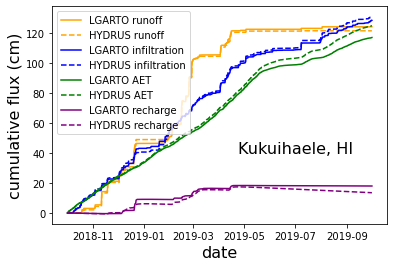

In [279]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

plt.text(x=times_bmi[4900], y=40, s='Kukuihaele, HI', fontsize = 16)

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[1]]*m_to_cm),'b',label='C (bmi)',color='orange')
plt.plot(HYDRUS_output[vars_hydrus[1]],'k',linestyle='dashed',label='Hydrus',color='orange')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[2]]*m_to_cm),'b',label='C (bmi)',color='blue')
plt.plot(HYDRUS_output[vars_hydrus[2]],'k',linestyle='dashed',label='Hydrus',color='blue')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[3]]*m_to_cm),'b',label='C (bmi)',color='green')
plt.plot(HYDRUS_output[vars_hydrus[3]],'k',linestyle='dashed',label='Hydrus',color='green')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm),'b',label='C (bmi)',color='purple')
plt.plot(-1*HYDRUS_output[vars_hydrus[4]],'k',linestyle='dashed',label='Hydrus',color='purple')

leg = plt.legend()#(handles=[runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS],labels=["LGARTO", "HYDRUS", "theta_e", "capillary head = -depth"])

mylabels = ['LGARTO runoff','HYDRUS runoff','LGARTO infiltration','HYDRUS infiltration','LGARTO AET','HYDRUS AET','LGARTO recharge','HYDRUS recharge']

plt.legend(labels=mylabels, ncol=1)
# plt.legend(labels=mylabels, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)

plt.ylabel("cumulative flux (cm)",fontsize=16)
plt.xlabel("date",fontsize=16)
# plt.xlim(times_bmi[0],times_bmi[2000])
# plt.ylim(-3,45)

# plt.vlines(times_bmi[4400], 0, 120, colors ="red")

# plt.tight_layout(rect=[0, 0, 1, 1.0])

if (save_outfile):
    plt.savefig(outfile_summpary_plot,dpi=400)

In [280]:
runoff_LGARTO = data_c_vars[vars_bmi[1]]*m_to_cm

runoff_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
#     if i!=1:
    runoff_HYDRUS.append(HYDRUS_output['sum(RunOff'][i] - HYDRUS_output['sum(RunOff'][i-1])

print("KGE in runoff: ")
print(hydroeval.kge(np.array(runoff_LGARTO), np.array(runoff_HYDRUS))[0][0])

print("NSE in runoff: ")
print(hydroeval.nse(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("percent bias in runoff: ")
print(hydroeval.pbias(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("RMSE in runoff (cm/h): ")
print(hydroeval.rmse(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("cumulative runoff for LGARTO (cm): ")
print(np.sum(runoff_LGARTO))

print("cumulative runoff for HYDRUS (cm): ")
print(np.sum(runoff_HYDRUS))

print("difference (cm): ")
print(np.sum(runoff_HYDRUS) - np.sum(runoff_LGARTO))

KGE in runoff: 
0.9686252062578338
NSE in runoff: 
0.958315963554481
percent bias in runoff: 
-2.1964336611193773
RMSE in runoff (cm/h): 
0.024489147239718873
cumulative runoff for LGARTO (cm): 
123.9540543875717
cumulative runoff for HYDRUS (cm): 
121.29
difference (cm): 
-2.6640543875716958


In [281]:
np.sum(runoff_HYDRUS) == HYDRUS_output['sum(RunOff'][-1]

True

In [282]:
infil_LGARTO = data_c_vars[vars_bmi[2]]*m_to_cm
infil_HYDRUS = HYDRUS_output['sum(Infil']

infil_HYDRUS = np.array(infil_HYDRUS)
infil_HYDRUS_cumulative = HYDRUS_output['sum(Infil']

i=0
for item in infil_HYDRUS:
#     print(item)
    if (i==0):
        item = item
    else:
        item = item - infil_HYDRUS_cumulative[i-1]
    infil_HYDRUS[i] = item
    i = i + 1
    
        
print("KGE in infiltration: ")
print(hydroeval.kge(np.array(infil_LGARTO), np.array(infil_HYDRUS))[0][0])

print("NSE in infiltration: ")
print(hydroeval.nse(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("percent bias in infiltration: ")
print(hydroeval.pbias(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("RMSE in infiltration (cm/h): ")
print(hydroeval.rmse(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("cumulative infiltration for LGARTO (cm): ")
print(np.sum(infil_LGARTO))

print("cumulative infiltration for HYDRUS (cm): ")
print(np.sum(infil_HYDRUS))

print("difference (cm): ")
print(np.sum(infil_HYDRUS) - np.sum(infil_LGARTO))

KGE in infiltration: 
0.9002555934887003
NSE in infiltration: 
0.8486105298745776
percent bias in infiltration: 
2.082503159175155
RMSE in infiltration (cm/h): 
0.024534021801603
cumulative infiltration for LGARTO (cm): 
128.2425456124283
cumulative infiltration for HYDRUS (cm): 
130.97
difference (cm): 
2.7274543875716972


In [283]:
np.sum(infil_HYDRUS) == HYDRUS_output['sum(Infil'][-1]

True

In [284]:
AET_LGARTO = data_c_vars[vars_bmi[3]]*m_to_cm
# AET_LGARTO = AET_LGARTO[:-1]

AET_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
#     if i!=1:
    AET_HYDRUS.append(HYDRUS_output[')   sum(vRoot'][i] - HYDRUS_output[')   sum(vRoot'][i-1])

print("KGE in AET: ")
print(hydroeval.kge(np.array(AET_LGARTO), np.array(AET_HYDRUS))[0][0])

print("NSE in AET: ")
print(hydroeval.nse(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("percent bias in AET: ")
print(hydroeval.pbias(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("RMSE in AET (cm/h): ")
print(hydroeval.rmse(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("cumulative AET for LGARTO (cm): ")
print(np.sum(AET_LGARTO))

print("cumulative AET for HYDRUS (cm): ")
print(np.sum(AET_HYDRUS))

print("difference (cm): ")
print(np.sum(AET_HYDRUS) - np.sum(AET_LGARTO))

KGE in AET: 
0.9246240481466281
NSE in AET: 
0.9837277825412757
percent bias in AET: 
6.341233292735006
RMSE in AET (cm/h): 
0.0029656888074032816
cumulative AET for LGARTO (cm): 
116.8112138373009
cumulative AET for HYDRUS (cm): 
124.72
difference (cm): 
7.908786162699101


In [285]:
np.sum(AET_HYDRUS) == HYDRUS_output[')   sum(vRoot'][-1]

True

In [286]:
rch_LGARTO = data_c_vars[vars_bmi[5]]*m_to_cm

rch_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
#     if i!=1:
    rch_HYDRUS.append(-1*(HYDRUS_output[')    sum(vBot'][i] - HYDRUS_output[')    sum(vBot'][i-1]))

print("KGE in recharge: ")
print(hydroeval.kge(np.array(rch_LGARTO), np.array(rch_HYDRUS))[0][0])

print("NSE in recharge: ")
print(hydroeval.nse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("percent bias in recharge: ")
print(hydroeval.pbias(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("RMSE in recharge (cm/h): ")
print(hydroeval.rmse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("cumulative recharge for LGARTO (cm): ")
print(np.sum(rch_LGARTO))

print("cumulative recharge for HYDRUS (cm): ")
print(np.sum(rch_HYDRUS))

print("difference (cm): ")
print(np.sum(rch_HYDRUS) - np.sum(rch_LGARTO))


KGE in recharge: 
-0.589624844187109
NSE in recharge: 
-3.9477130894560366
percent bias in recharge: 
-33.031436450152555
RMSE in recharge (cm/h): 
0.015722271331337134
cumulative recharge for LGARTO (cm): 
18.0031442946485
cumulative recharge for HYDRUS (cm): 
13.532999999886759
difference (cm): 
-4.470144294761742


In [287]:
abs(np.sum(rch_HYDRUS) - -1*HYDRUS_output[')    sum(vBot'][-1]) < 0.001

True

In [288]:
rch_HYDRUS=np.array(rch_HYDRUS)
rch_LGARTO=np.array(rch_LGARTO)

rch_HYDRUS_ind=np.array(rch_HYDRUS)
rch_LGARTO_ind=np.array(rch_LGARTO)

i = 0
for _ in rch_HYDRUS:
    if i>0:
        rch_HYDRUS[i] = np.sum(rch_HYDRUS_ind[0:i])
        rch_LGARTO[i] = np.sum(rch_LGARTO_ind[0:i])
    i=i+1

# plt.plot(rch_LGARTO)
# plt.plot(rch_HYDRUS)

print("KGE in cumulative recharge: ")
print(hydroeval.kge(np.array(rch_LGARTO), np.array(rch_HYDRUS))[0][0])

print("NSE in cumulative recharge: ")
print(hydroeval.nse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("percent bias in cumulative recharge: ")
print(hydroeval.pbias(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("RMSE in cumulative recharge (cm): ")
print(hydroeval.rmse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

KGE in cumulative recharge: 
0.7972048984585854
NSE in cumulative recharge: 
0.8788650288511605
percent bias in cumulative recharge: 
-16.352623425091874
RMSE in cumulative recharge (cm): 
2.2509303442969113
